In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
import sys
import json
import pathlib

import nxsdk.api.n2a as nx

import encoding
import radar

In [4]:
# Only the 900 first samples contain information
# lin rate encoding 
# config_file = "scenario1_default.json"
#ttsp encoding
config_file = "scenario4_timecoding.json"
fpath, dft_args = radar.load_config(config_file)
data_cube = radar.bbm_read(fpath)
print(len(data_cube[0]))
#### only 1D
chirp_n = 77
raw_data = [channel[chirp_n] for channel in data_cube]
print(len(raw_data[0]))

n_samples = 100
#n_samples = raw_data[0].size
n_chirps = 1

### list with len 900
encoded_cube = [radar.data_encoding(ch, dft_args) for ch in raw_data]
#linear_rate_encoding(raw_data, dft_args).astype(int)
#print(encoded_cube)

/home/negin/miniconda2/envs/loihi/nxsdk-apps/tutorials/ipython/sdft/data/BBM/scenario4/samples_ch_3_scenario4.txt
128
900


In [5]:
net = nx.NxNet()

ingen = net.createSpikeGenProcess(numPorts=n_samples)

l1 = []
l1_g = net.createCompartmentGroup()
for i in range(n_samples):
    l1_p = nx.CompartmentPrototype(vThMant=1000,
                                   biasMant = 0,
                                   biasExp = 6,
                                   compartmentCurrentDecay=4095,
                                   compartmentVoltageDecay=0,
                                   functionalState=2,
                                   logicalCoreId=int(i/10))
    l1.append(net.createCompartment(prototype=l1_p))
l1_g.addCompartments(l1)


#l2 = []
#l2_g = net.createCompartmentGroup()
#for i in range(n_samples):
#    l2_p = nx.CompartmentPrototype(vThMant=10,
#                                   biasMant = 0,
#                                   biasExp = 6,
#                                   compartmentCurrentDecay=4095,
#                                   compartmentVoltageDecay=0,
#                                   functionalState=2,
#                                   logicalCoreId=int(i/30))
#    l2.append(net.createCompartment(prototype=l2_p))
#l2_g.addCompartments(l2)



# Connect spike generators to compartments
in_l1 = nx.ConnectionPrototype()
#l1_l2 = nx.ConnectionPrototype()


diag = np.zeros((n_samples,n_samples), int)
np.fill_diagonal(diag, 1)
#array_data = np.array(encoded_cube)
#in_l1_w = diag * array_data
in_l1_w = diag
#print(array_data)

#l1_l2_w = np.ones((n_samples,n_samples), int)

ingen.connect(l1_g, prototype=in_l1, weight=in_l1_w*100)
#l1_g.connect(l2_g, prototype=l1_l2, weight=l1_l2_w*100)

# weights are FT weights....
# and when we have all the input... then charging phase...

    
l1_p_v = []
l1_p_s = []
#l2_p_v = []
#l2_p_s = []
l1_ran = np.random.choice(n_samples, 10)
#l2_ran = np.random.choice(900, 10)

for i in l1_ran:
    l1_p_v.append(l1_g.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][i])
#    l1_p_s.append(l1_g.probe(nx.ProbeParameter.SPIKE)[0][i])

#for i in l2_ran:
#    l2_p_v.append(l1_g.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][i])
#    l2_p_s.append(l1_g.probe(nx.ProbeParameter.SPIKE)[0][i])

In [6]:
#n_steps = encoded_cube.shape[2]
#print(n_steps)

#red_spike_times = []
        
#time_scale = np.arange(0,n_steps,1)
#for i in range(n_samples):
#    spike_t = time_scale * encoded_cube[0,i,:]
#    red_spike_t = spike_t[spike_t != 0]
#    red_spike_times.append(red_spike_t)
    #print(red_spike_t)
#    ingen.addSpikes(spikeInputPortNodeIds=i, spikeTimes=red_spike_t.tolist())




array_data = np.round(np.array(encoded_cube),3)
condesed = np.split(array_data[0], 9)[0]
print(condesed)

# so for fun we say 1ms ⁼ 1cycle
sim_t = 100
step = 0.01 


for cycle in range(sim_t):
    active_neurons = (condesed < (cycle*step)) & (condesed >= ((cycle-1)*step))
    active_neuron_ports = np.nonzero(active_neurons)[0]
    if active_neuron_ports.size != 0:
        for port in active_neuron_ports:
            print(str(cycle) + " " +str(port))
            ingen.addSpikes(spikeInputPortNodeIds=port, spikeTimes=[cycle+1])
net.run(sim_t)

net.stop()
net.disconnect()


#### network without spikes

[0.719 0.73  0.804 0.785 0.746 0.787 0.803 0.784 0.781 0.79  0.795 0.805
 0.837 0.858 0.845 0.838 0.875 0.943 0.875 0.947 0.918 0.936 0.965 0.928
 0.97  0.919 0.943 0.947 1.    0.933 0.966 0.926 0.96  0.925 0.953 0.902
 0.891 0.92  0.899 0.908 0.862 0.832 0.828 0.882 0.825 0.801 0.741 0.757
 0.702 0.685 0.685 0.653 0.646 0.591 0.608 0.57  0.57  0.531 0.527 0.497
 0.473 0.466 0.49  0.469 0.442 0.452 0.447 0.44  0.455 0.456 0.437 0.442
 0.462 0.479 0.517 0.506 0.432 0.489 0.47  0.544 0.547 0.536 0.57  0.581
 0.642 0.636 0.652 0.641 0.683 0.624 0.648 0.716 0.707 0.722 0.744 0.741
 0.713 0.727 0.72  0.78 ]
44 70
44 76
45 64
45 66
45 67
45 71
46 65
46 68
46 69
47 61
47 63
47 72
47 78
48 60
48 73
49 77
50 59
50 62
51 75
52 74
53 58
54 57
54 81
55 79
55 80
57 55
57 56
57 82
59 83
60 53
61 54
63 89
64 85
65 52
65 84
65 87
65 90
66 51
66 86
69 49
69 50
69 88
71 48
71 92
72 0
72 91
72 96
73 93
73 97
73 98
74 1
75 4
75 46
75 94
75 95
76 47
79 3
79 5
79 7
79 8
79 99
80 9
80 10
81 2
81 6
81 11
81 4

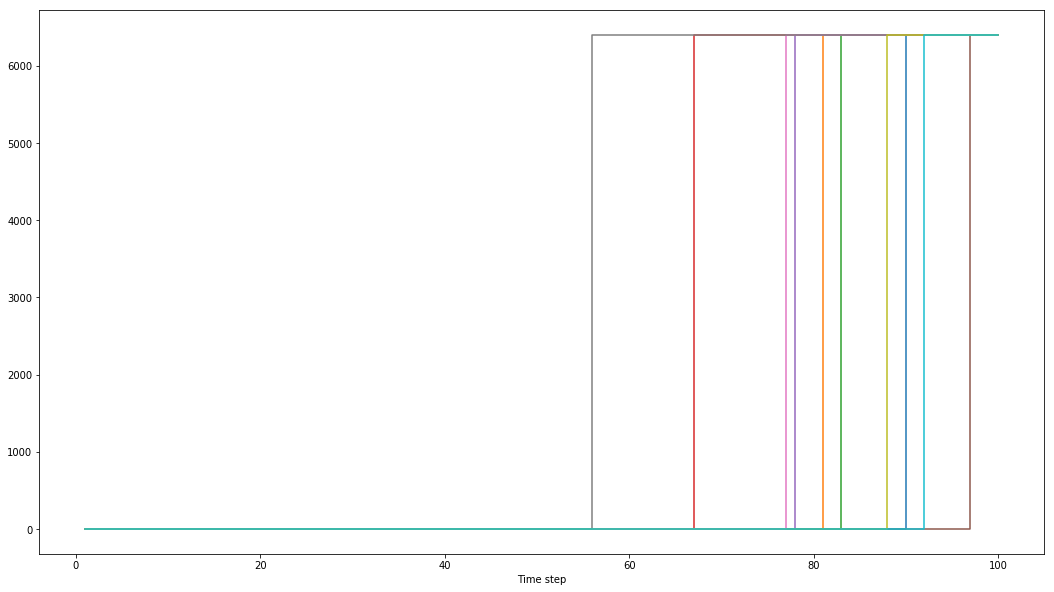

In [7]:
plt.figure(1, figsize=(18,10))

#plt.plot(red_spike_times[1],100 * np.ones(len(red_spike_times[1])), 'bo')

for i in range(len(l1_p_v)):
    #print(red_spike_times[i])
    #if red_spike_times[i][0] <= 100:
        #vprobe[i].plot()
        #plt.plot(red_spike_times[i][0],100, 'bo')
    l1_p_v[i].plot()
    #l2_p_v[i].plot()
    #plt.plot(red_spike_times[i],100 * np.ones(len(red_spike_times[i])), 'bo')